1 0


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


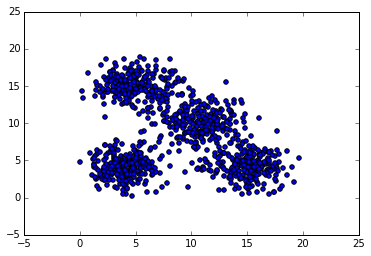

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(53080)
mean1 = [4, 4]
cov1 = [[2.5, 0], [0, 2.5]]
x1, y1 = np.random.multivariate_normal(mean1, cov1, 250).T
mean2 = [11, 10]
cov2 = [[3.5, 0], [0, 2.5]]
x2, y2 = np.random.multivariate_normal(mean2, cov2, 250).T
mean3 = [5, 15]
cov3 = [[3.5, 0], [0, 2.5]]
x3, y3 = np.random.multivariate_normal(mean3, cov3, 250).T
mean4 = [15, 4]
cov4 = [[3.5, 0], [0, 2.5]]
x4, y4 = np.random.multivariate_normal(mean4, cov4, 250).T

x = np.r_[x1,x2,x3,x4]
y = np.r_[y1,y2,y3,y4]

ind1 = []
ind2 = []

for i in range(len(x)):
    ind1.append(np.logical_or(x[i]<0, x[i]>20))
    ind2.append(np.logical_or(y[i]<0, y[i]>20))
print(np.sum(ind1),np.sum(ind2))

for i in range(len(x)):
    if np.logical_or(x[i]<0, x[i]>20):
        x[i] = np.random.rand(1)*20
    if np.logical_or(y[i]<0, y[i]>20):
        y[i] = np.random.rand(1)*20
plt.scatter(x, y)
plt.axis([-5,25,-5,25])
plt.show()

In [12]:
def Outbreaks(Size,N,Y0,farms,start,end,x,y,Cows,Sheep,Maxtime=1000):
    #This is an attempt of converting the Matlab Program 7.6 Code into Python
    import numpy as np
    import pandas as pd
    from math import pi
    #Generate dataset (assume there are the same amount of animals at each farm)
    #np.random.seed(10)
    #x = Size*np.random.rand(N)
    #np.random.seed(11)
    #y = Size*np.random.rand(N)
    #Cows = np.array([250]*N)  #Number of cows at each farm
    #Sheep = np.array([250]*N)  #Number of cows at each farm
    Status = np.array([0]*N)    #Initial Status of each farm
    for i in range(Y0):
        Status[i] = 1

    #Cows are 10.5 times more susceptible to disease than sheep
    Suscept = Sheep+10.5*Cows
    Transmiss = 5.1e-7*Sheep + 7.7e-7*Cows 

    #Calculates which grid square a particular location is in (turn a 2-d coordinate into a scalar)
    def WhichGrid(x,y,XRange,YRange,XNum,YNum):
        #Essentially: floor(Unif[0,1)griddim)griddim+floor(Unif[0,1)griddim)+1
        #Returns a number from 1 to griddim^2
        return(np.floor(x*(XNum/XRange))*YNum+np.floor(y*(YNum/YRange))+1)

    #Set up the grid
    grid = WhichGrid(x,y,Size,Size,10.0,10.0)
    tmp = sorted(grid) #Sort grid values
    i = np.argsort(grid) #get indexed values after sort
    x = x[i]
    y = y[i]
    Status = Status[i]
    grid = grid[i]
    Xgrid = []
    Ygrid = []
    Num = []
    first_in_grid = []
    last_in_grid = []
    Max_Sus_grid = []
    for i in range(1,int(max(grid))+1):
        #turn the grid square number into an x-coordinate and y-coordinate (should not exceed XNum)
        Xgrid.append(np.floor((i-1)/10))
        Ygrid.append((i-1)%10)
        m = np.array(np.where(grid==i))
        Num.append(m.shape[1])
    
        if Num[i-1] > 0:
            first_in_grid.append(m.min()+1) #Add the "+1" here so the indicies match those in the Keeling code
            last_in_grid.append(m.max()+1)
            Max_Sus_grid.append(Suscept[m].max())
        else:
            first_in_grid.append(0)
            last_in_grid.append(-1)
            Max_Sus_grid.append(0)

    #Work out grid to maximum grid transmission probabilities
    from numpy import ndarray
    MaxRate = ndarray((max(grid),max(grid)))
    def Kernel(dist_squared):
        dist_squared = np.asarray(dist_squared)
        is_scalar = False if dist_squared.ndim > 0 else True
        dist_squared.shape = (1,)*(1-dist_squared.ndim) + dist_squared.shape
        K = 1 / (pi * (1 + dist_squared**2))
        K[(dist_squared < 0.0138)] = 0.3093
        K[(dist_squared > 60*60)] = 0
        return(K if not is_scalar else K[0])

    #Determine maximum number of animals to be infected in each grid square

    for i in range (1,int(max(grid))+1):
       for j in range(1,int(max(grid))+1):
           if ((i-1)==(j-1)) | (Num[i-1]==0) | (Num[j-1] == 0):
               MaxRate[i-1,j-1] = np.inf
           else:
               Dist2 = (Size*max([0,(abs(Xgrid[i-1]-Xgrid[j-1])-1)])/10)**2+(Size*max([0,(abs(Ygrid[i-1]-Ygrid[j-1])-1)])/10)**2
               MaxRate[i-1,j-1] = Max_Sus_grid[j-1]*Kernel(Dist2)

    #Susceptible, Exposed, Infectious, Reported.==> latent period is 4 days
    i=1; S=len(np.where(Status==0)); E=len(np.where(np.logical_and(Status>0, Status<=5)));I=len(np.where(np.logical_and(Status>5, Status<=9))); R=len(np.where(Status==10)); R2=len(np.where(Status>9)); CullSheep=0; CullCattle=0;
    i=i+1;  IterateFlag=1;

    def Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate):
        Event = 0*Status
        INF = np.where(np.logical_and(Status>5, Status<=12))[0]
        NI = INF.size # Note reported farms still infectious
        IGrids = grid[INF]-1
        
        for ii in range(NI):
            INFi = INF[ii]
            trans = np.multiply(-Transmiss[INFi],Num) #transmissibility of infected farm to all other grid squares 
            maxr = MaxRate[IGrids[ii],:] #max number of animals to be infected in infected grid square
            # Elementwise multiplication
            rate = np.multiply(trans, maxr) #max number of animals to be infected in each grid square based on infected grid square
            MaxProb = 1 - np.exp(rate) #Max probability that infected farm infected noninfected farm
            rng = np.random.rand(len(MaxProb))
            m = np.where((MaxProb - rng)>0)[0]  #these grid squares need further consideration
            for n in range(len(m)):
                s = 1
                M = m[n]
                PAB = 1 - np.exp(-Transmiss[INFi]*MaxRate[IGrids[ii],M]) #Max probability that infected farm infects noninfected farms under consideration
                if (PAB == 1):
                    # Calculate the infection probability for each farm in the susceptible grid
                    leng = last_in_grid[M]-first_in_grid[M]+1
                    R = np.random.rand(leng)
                    for j in range(leng):
                        ind1 = first_in_grid[M]+j-1
                        Q = 1 - np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1]**2+(y[INFi]-y[ind1])**2)))
                        if ((R[j] < Q) & (Status[ind1] == 0)):
                            Event[ind1] = 1
                else:
                    R = np.random.rand(Num[M])
                    # Loop through all susceptible farms in the grids where an infection event occurred.  
                    for j in range(Num[M]):
                        P = 1 - s*(1 - PAB)**(Num[M] - j)
                        if (R[j] < (PAB / P)):
                            s = 0
                            ind1=first_in_grid[M]+j-1
                            Q=1-np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1]**2+(y[INFi]-y[ind1])**2)))
                            if ((R[j]< Q/P) & (Status[ind1] == 0)):
                                Event[ind1] = 1
        # Evolve the infection process of those farms which have been exposed and already infectious ones.  
        Status[Status > 0] += 1
        Status = Status + Event
        m=np.where(Status==13); # Initiate Ring Culling Around Reported Farm
        for i in range(len(m)):
            Status[m[i]]=-1;
        return {'Status':Status,'NI':NI}
    
    S=[]
    E=[]
    I=[]
    R=[]
    R2=[]
    CullSheep=[]
    CullCattle=[]
    t=[]
    t.append(0)
    results = np.c_[np.array([1]*N),np.arange(1,N+1),np.array([0]*N)]
    
    while(np.logical_and(t[-1]<Maxtime, IterateFlag)):
        Status=Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate)['Status']
        Sus=np.where(Status==0)[0]; Exp=np.where(np.logical_and(Status>0, Status<=5))[0]; Inf=np.where(np.logical_and(Status>5, Status<=9))[0]; 
        Rep=np.where(Status>9)[0]; Culled=np.where(Status<0)[0];
        S.append(len(Sus)); E.append(len(Exp)); I.append(len(Inf)); R.append(len(np.where(Status==10))); R2.append(len(Rep));CullSheep.append(np.sum(Sheep[Culled])); CullCattle.append(np.sum(Cows[Culled]))
        t.append(t[i-2]+1);i+=1;
    
        #This is how I stop the simulation (all farms are infected)
        if t[-1]>5:
            if (E[-4]+I[-4]+R2[-4]==0):
                IterateFlag=0
        from scipy.stats import itemfreq
        sim_num = np.array([i-1]*N)
        seq = np.arange(1,N+1)
        results_full = np.r_[results,np.c_[sim_num,seq,Status]]
        results = results_full

    #Return information regarding only farm of interest
    this = results_full[np.logical_or.reduce([results_full[:,1] == x for x in farms])]
    #Extract rows relating to timepoint of interest
    no_this = this[this[:,0]==end]
    #turn status to an indicator
    Status_ind = (np.logical_and(no_this[:,2]>5,no_this[:,2]<13)).astype(int)
    #Calculate distance to index farm - first infected is first in list of coords
    coords = list(zip(x,y))
    index = np.array((coords[0][0],coords[0][1]))
    dist = []
    dist.append(0)
    for i in range(1,N):
        b = np.array((coords[i][0],coords[i][1]))
        dist.append(np.linalg.norm(b-index))
    to_return = np.c_[no_this[:,1],Status_ind,dist,Cows,Sheep]
    #Returns array: farmID, Status_ind, dist_to_index, num_Cows,num_Sheep
    return(to_return)
        
  

In [54]:
import numpy as np
from random import randint
Size = 20
N = 1000   
np.random.seed(13)
Cows = np.array([randint(200,500) for p in range(N)])
np.random.seed(14)
Sheep = np.array([randint(200,500) for p in range(N)]) 
Outbreak = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),start=20,end=30,x=x,y=y,Cows=Cows,Sheep=Sheep)
Num_outbreaks = 500
for i in range(Num_outbreaks):
    new_Outbreak = np.r_[Outbreak,Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),start=20,end=30,x=x,y=y,Cows=Cows,Sheep=Sheep)]
    Outbreak = new_Outbreak 
run = np.ravel(list([i]*N for i in range(1,Num_outbreaks+2)))
data = np.c_[run,Outbreak]

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:92: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:101: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [55]:
#For ease turn data array into data frame
import pandas as pd
df = pd.DataFrame(data)
df.columns = ['run','farmID','Status','DistToIndex','NumCows','NumSheep']
df.shape

(501000, 6)

In [56]:
#Group by farmID then add across farmIDs 
farm_Status = df[['Status']].groupby(df.farmID)
sum_Status = farm_Status.agg(np.sum)
#Get rid of hierarchical header for data merge
sum_Status.columns = sum_Status.columns.get_level_values(0)
sum_Status2 = pd.DataFrame(sum_Status).reset_index()
#Add rest of data covariates
subset = df[:1000][['farmID','DistToIndex','NumCows','NumSheep']]
clust_rand_size = pd.concat([sum_Status2, subset], axis=1, join_axes=[subset.index])
clust_rand_size

,farmID,Status,farmID,DistToIndex,NumCows,NumSheep
0,1,56,1,0.000000,490,396
1,2,212,2,0.503829,220,451
2,3,0,3,2.087818,493,298
3,4,15,4,1.263809,244,281
4,5,5,5,1.521342,358,359
5,6,0,6,1.631660,492,238
6,7,3,7,1.000752,398,406
7,8,0,8,1.693373,268,203
8,9,3,9,1.025316,267,288
9,10,5,10,1.075198,373,402


In [57]:
#Save (or pickle) the dataset for future use
clust_rand_size.to_pickle('/Users/sandyalakkur/Documents/GradSchool/Research/AMFMDIdeas/clust_rand_size.pkl') 

In [ ]:
#Read the pickled dataset back in - prevents having to run all above code again
import pandas as pd
clust_rand_size = pd.read_pickle('/Users/sandyalakkur/Documents/GradSchool/Research/AMFMDIdeas/clust_rand_size.pkl')

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


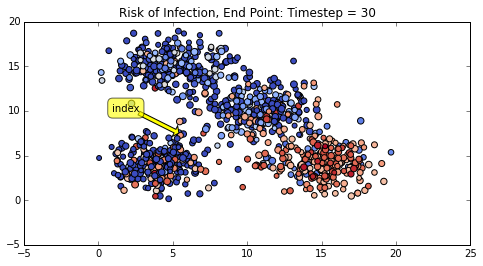

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.scatter(x,y,c=clust_rand_size['Status'],cmap=plt.cm.coolwarm,s=(Cows+Sheep)/20)
plt.title('Risk of Infection, End Point: Timestep = 30')
plt.annotate('index', xy = (x[0], y[0]), xytext = (-40, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round, pad=0.5', fc = 'yellow', alpha = 0.6),
        arrowprops=dict(facecolor='yellow', shrink=0.00005))


plt.show()

In [59]:
dist_diff = clust_rand_size['DistToIndex'] - clust_rand_size['DistToIndex'].mean()
cows_diff = clust_rand_size['NumCows'] - clust_rand_size['NumCows'].mean()
sheep_diff = clust_rand_size['NumSheep'] -clust_rand_size['NumSheep'].mean()
status = clust_rand_size['Status']
from pymc import Normal, Binomial, Gamma, Lambda, invlogit, MCMC, Matplot, Bernoulli, MAP, AdaptiveMetropolis
#N = df.shape[0]

def pooled_model():
    
    # Common slope & intercept prior
    intercept = Normal('intercept', mu=0., tau=0.001, value = 0.5) 
    
    first_coef = Normal('first_coef', mu=0., tau=0.001, value = -0.05)
    
    b = Normal('b', mu=0., tau=0.001, value = [0]*2)
    
    #likelihood model
    prob = Lambda('prob', lambda intercept=intercept,first_coef=first_coef, b=b: invlogit(intercept + first_coef*dist_diff + b[0]*cows_diff 
                                               + b[1]*sheep_diff))
    
    y = Binomial('y', n=501, p=prob, value=status, observed=True)
    
    return locals()

In [60]:
chains = 2
iterations = 10000
burn = 4000
M_pooled = MCMC(pooled_model())
M_map = MAP(pooled_model())
M_pooled = MCMC(M_map)
#M_pooled.use_step_method(AdaptiveMetropolis, M_pooled.b)
for i in range(chains):
    M_pooled.sample(iterations, burn)

 [-----------------100%-----------------] 10000 of 10000 complete in 24.2 sec

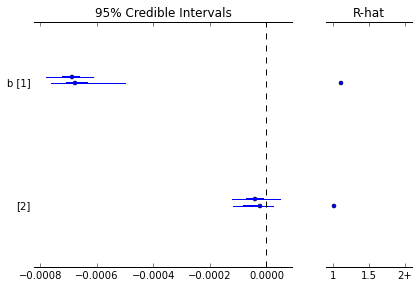

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.b)

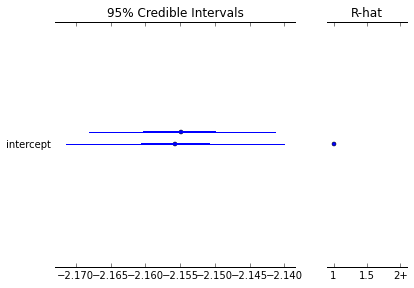

In [62]:
Matplot.summary_plot(M_pooled.intercept)

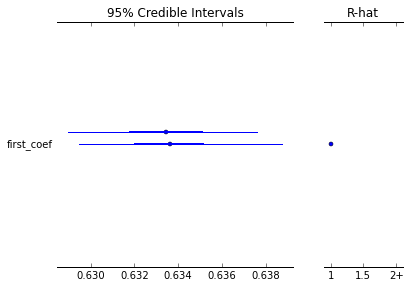

In [63]:
Matplot.summary_plot(M_pooled.first_coef)

Plotting intercept


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


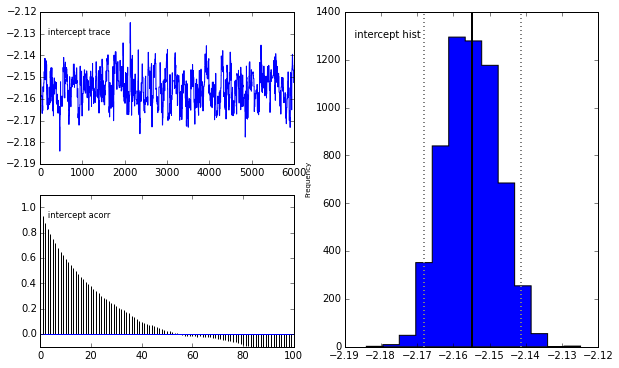

In [64]:
Matplot.plot(M_pooled.intercept)

Plotting b_0
Plotting b_1


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


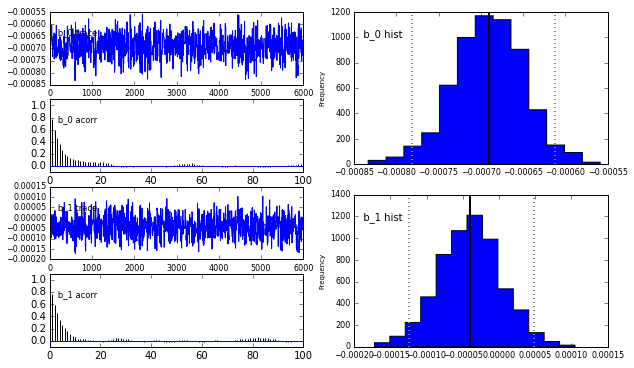

In [65]:
Matplot.plot(M_pooled.b, common_scale=False)

Plotting first_coef


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


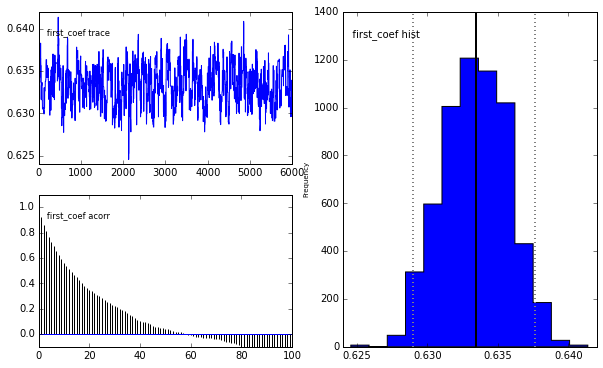

In [66]:
Matplot.plot(M_pooled.first_coef, common_scale=False)

In [67]:
from pymc import gelman_rubin
gelman_rubin(M_pooled)

{'b': [1.1130356570523612, 1.0047724928586641],
 'first_coef': 1.002256701208623,
 'intercept': 1.0030886100404894,
 'prob': [1.0003374165255512,
  1.0157566480633973,
  1.0019542332531004,
  1.0106191208829443,
  1.0019117694251771,
  1.0021247902268151,
  1.000546452966985,
  1.0067322953388442,
  1.0081030354653155,
  1.0015070243124733,
  1.0022877697862576,
  1.009230591454926,
  1.0017000601661044,
  0.99984292367398786,
  1.0004088464527621,
  1.0149746404920552,
  1.0118062143239612,
  1.0002965948028144,
  1.000635026594443,
  1.0000995480095629,
  1.0000485357169986,
  1.0134982166134741,
  1.0012327613660015,
  0.99991347223306593,
  1.0394564730405729,
  1.0177463750360933,
  1.0117805275010563,
  1.0033106441088444,
  1.0805349779015074,
  1.0612215517476109,
  1.0123428689771354,
  1.0187749999863516,
  1.0123031036991021,
  1.0039501841404426,
  1.0053166149874551,
  1.0094899664099488,
  1.0101570733129686,
  1.0097591761823159,
  1.0045172433373426,
  1.003239784673344

In [68]:
M_pooled.b.summary()


b:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.001           0.0              0.0              [-0.001 -0.001]
	-0.0             0.0              0.0                    [-0.  0.]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.001           -0.001          -0.001         -0.001        -0.001
	-0.0             -0.0            -0.0           -0.0          0.0
	


In [69]:
M_pooled.intercept.summary()


intercept:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-2.155           0.008            0.0              [-2.169 -2.14 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-2.17            -2.16           -2.155         -2.15         -2.14
	


In [70]:
M_pooled.first_coef.summary()


first_coef:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.633            0.002            0.0              [ 0.629  0.638]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.629            0.632           0.634          0.635         0.638
	


In [71]:
import numpy as np
#Intercept: mean, 2.5%, 97.5%
(M_pooled.trace('intercept')[:].mean(),np.percentile(M_pooled.trace('intercept')[:],2.5),np.percentile(M_pooled.trace('intercept')[:],97.5))

(-2.1549567310582023, -2.1682736246404306, -2.1414555917652769)

In [72]:
#distance: mean, 2.5%, 97.5%
(M_pooled.trace('first_coef')[:].mean(),np.percentile(M_pooled.trace('first_coef')[:],2.5),np.percentile(M_pooled.trace('b')[:],97.5))

(0.63339664761661807, 0.6290843384781164, 3.4753568027574857e-05)

In [73]:
# #cows: mean, 2.5%, 97.5%
(M_pooled.trace('b')[:,0].mean(),np.percentile(M_pooled.trace('b')[:,0],2.5),np.percentile(M_pooled.trace('b')[:,0],97.5))

(-0.00069116877158180608, -0.00077761573067995399, -0.00060609715577534997)

In [74]:
# #sheep: mean, 2.5%, 97.5%
(M_pooled.trace('b')[:,1].mean(),np.percentile(M_pooled.trace('b')[:,1],2.5),np.percentile(M_pooled.trace('b')[:,1],97.5))

(-3.9731404945291881e-05, -0.00012751268132562608, 4.57740961924038e-05)